   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN  

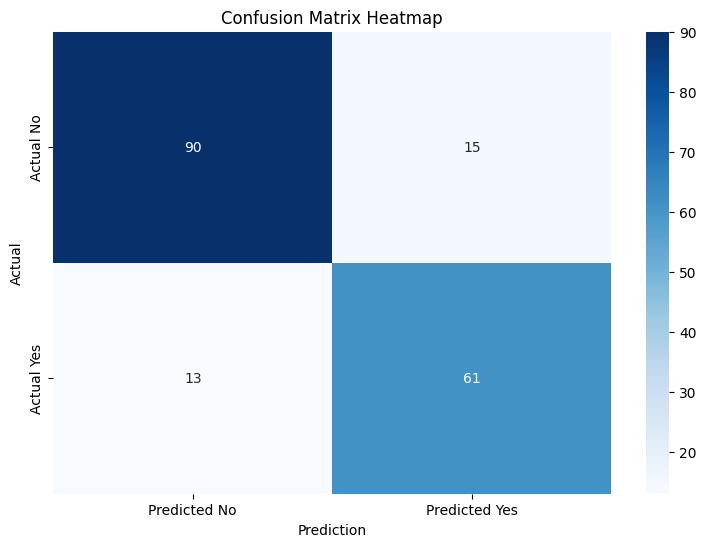

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust display settings to prevent truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Load the Titanic dataset
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
data = pd.read_csv(url)

# Display the first few rows of the dataset
print(data.head())

# Data preprocessing

# Handle missing values more effectively
imputer = SimpleImputer(strategy='mean')
data['Age'] = imputer.fit_transform(data[['Age']])
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data = data.drop('Cabin', axis=1)

# Feature engineering
data['FamilySize'] = data['SibSp'] + data['Parch']
data['IsAlone'] = (data['FamilySize'] == 0).astype(int)
data['FarePerPerson'] = data['Fare'] / (data['FamilySize'] + 1)

# Convert categorical variables to numerical
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)

# Drop irrelevant columns
data = data.drop(['Name', 'Ticket', 'PassengerId'], axis=1)

# Split the data into features and target variable
X = data.drop('Survived', axis=1)
y = data['Survived']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the model using GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best estimator
best_gbc = grid_search.best_estimator_

# Make predictions
y_pred_prob = best_gbc.predict_proba(X_test)[:, 1]

# Adjust the threshold
threshold = 0.4  # You can tune this threshold
y_pred = (y_pred_prob >= threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(class_report)

# Cross-validation score
cv_scores = cross_val_score(best_gbc, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {np.mean(cv_scores)}')

# Plot confusion matrix as heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()
